# Introducción a Pytorch. Entrenamiento de MLPs sobre la de datos Spam

### Procesamiento de Lenguaje Natural

**Pablo Martínez Olmos, Vanessa Gómez Verdejo, Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


# 1. Regresión logística con Pytorch

[Pytorch](https://pytorch.org/) es un entorno de código abierto para aprendizaje automático que acelera el camino desde la creación de prototipos de investigación hasta la implementación de producción. En particular, nos proporciona mecanismos de [diferenciación automática](https://proceedings.neurips.cc/paper/2018/file/770f8e448d07586afbf77bb59f698587-Paper.pdf) para optimización numérica que nos permitirán entrenar redes neuronales de forma sencilla y eficiente. 

En este primer notebook, aprenderemos a utilizar Pytorch para entrenar una regresión logística y una rede neuronal de tipo MLP en un problema de clasificación binaria.


In [3]:
import pandas as pd # pd is simply an alias 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' #High quality figures

## 1.2 Spam database

Carguemos la base de datos [spam](https://archive.ics.uci.edu/ml/datasets/spambase):
    
- 4601 observaciones (1813 spam, 39.4%)
- target binario: spam ($y=1$) o no spam ($y=0$)
- No disponemos de los textos, las observaciones están formadas por 57 variables continuas
  - 48 variables reales continuas en el intervalo [0,100] *word_freq_WORD*: frecuencia de aparición de la palabra *WORD* en el correo (en porcentaje)
  - 6 variables reales continuas en el intervalo [0,100] *char_freq_CHAR*: frecuencia de aparición del caracter *CHAR* en el correo (porcentaje)
  - 1 variable real continua: longitud promedio de secuencias de caracteres en mayúscula ininterrumpidos
  - 1 variable entera continua: longitud de la secuencia de mayúsculas ininterrumpida más larga
  - 1 variable entera continua: número total de mayúsculas en el correo


In [4]:
def load_spam():
    data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data',header=None)
    data.columns=["wf_make",         
        "wf_address",      
        "wf_all",          
        "wf_3d",           
        "wf_our",          
        "wf_over",         
        "wf_remove",       
        "wf_internet",     
        "wf_order",        
        "wf_mail",         
        "wf_receive",      
        "wf_will",         
        "wf_people",       
        "wf_report",       
        "wf_addresses",    
        "wf_free",         
        "wf_business",     
        "wf_email",        
        "wf_you",          
        "wf_credit",       
        "wf_your",         
        "wf_font",         
        "wf_000",          
        "wf_money",        
        "wf_hp",           
        "wf_hpl",          
        "wf_george",       
        "wf_650",          
        "wf_lab",          
        "wf_labs",         
        "wf_telnet",       
        "wf_857",          
        "wf_data",         
        "wf_415",          
        "wf_85",           
        "wf_technology",   
        "wf_1999",         
        "wf_parts",        
        "wf_pm",           
        "wf_direct",       
        "wf_cs",           
        "wf_meeting",      
        "wf_original",     
        "wf_project",      
        "wf_re",           
        "wf_edu",          
        "wf_table",        
        "wf_conference",   
        "cf_;",            
        "cf_(",            
        "cf_[",            
        "cf_!",            
        "cf_$",            
        "cf_#",            
        "cap_average", 
        "cap_longest", 
        "cap_total",
        "target"]
    return data

In [5]:
''' Data is stored in a Dataframe, a particular data type implemented in Pandas'''

data = load_spam()

print("Cargadas {0:d} observaciones con {1:d} columnas\n".format(len(data), len(data.columns)))
print("Ejemplos")
data.head()


Cargadas 4601 observaciones con 58 columnas

Ejemplos


,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,...,cf_;,cf_(,cf_[,cf_!,cf_$,cf_#,cap_average,cap_longest,cap_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


Separamos train/test, normalizamos ...

In [6]:
from scipy.stats import multivariate_normal, norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X0_spam = data[data.columns[:57]].values
Y_spam = data['target'].values

# Dividimos train/test. Normalizamos
X0_spam_train, X0_spam_test, Y_spam_train, Y_spam_test = train_test_split(
    X0_spam, Y_spam, test_size=0.3, random_state=42)
# X0--> Datos originales, X --> Normalizados

transformer_spam = StandardScaler().fit(X0_spam_train)  
X_spam_train = transformer_spam.transform(X0_spam_train)  
X_spam_test = transformer_spam.transform(X0_spam_test) 

## 1.2. Tensores en Pytorch

El tipo de dato básico en Pytorch se denomina [tensor](https://pytorch.org/docs/stable/tensors.html) y en muchos sentidos se utilizan como arrays en Numpy. PyTorch toma estos tensores y simplifica su traslado a las GPU para el procesamiento más rápido necesario al entrenar redes neuronales. También proporciona un módulo que calcula automáticamente los gradientes y otro módulo específicamente para construir redes neuronales.


### Crear y manipular tensores

In [7]:
import torch
torch.__version__

'1.7.1'

Creemos una función para manipular los tensores que utilizaremos para programar nuestro propio regresor logístico:

$$f(\mathbf{x}) = \frac{1}{1+\exp-(\mathbf{w}^T\mathbf{x}+w_0)}$$



In [8]:
def sigmoid(x):
    """ Sigmoid activation function 
    
        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

Ahora generemos unos pesos $\mathbf{w}$, $w_0$ aleatorios y también una entrada $\mathbf{x}$ aleatoria ...

In [9]:
torch.manual_seed(7) # Semilla aleatoria fija

# Vector x (1,5) aleatorio
feature_vector = torch.randn((1, 5))

# Vector de pesos con la misma dimensión de x
weights = torch.randn_like(feature_vector)
# Término de sesgo
bias = torch.randn((1, 1))

Los tensores PyTorch se pueden sumar, multiplicar, restar, etc., al igual que las matrices Numpy.

Al igual que en Numpy, podemos verificar los valores y dimensiones de un tensor:

In [10]:
print(feature_vector)
m,n = feature_vector.shape
print("Las dimensiones son {0},{1}".format(m,n))

tensor([[-0.1468,  0.7861,  0.9468, -1.1143,  1.6908]])
Las dimensiones son 1,5


> **Ejercicio**: Usando la función `sigmoid ()`, calcule la salida de un regresor logístico binario con vector de características de entrada `feature_vector`,  pesos ` features` y sesgo `bias`. Puede utilizar `*` para el producto elemento a elemento y la función [`torch.sum ()`] (https://pytorch.org/docs/stable/torch.html#torch.sum) para sumar todos los elementos de un tensor en una cierta dimensión.

In [11]:


y = ### YOUR CODE HERE

print("La salida del RL es {0}".format(y[0][0])) 

La salida del RL es 0.15950655937194824


> **Ejercicio**: Repita el ejercicio anterior utilizando la multiplicación matricial con [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul). Puede usar las funciones [`weights.reshape()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.reshape) o [`weights.view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) para reordenar un tensor:
>
> `weights.reshape(a, b)` o `weights.view(a, b)` devuelven  un nuevo tensor con los mismos datos que `weights` pero con dimensiones `(a, b)`.


In [1]:

y = # YOUR CODE HERE

SyntaxError: invalid syntax (<ipython-input-1-212791031014>, line 1)

In [13]:
print("La salida del RL es {0}".format(y[0][0])) 

La salida del RL es 0.15950657427310944


### Conversion a matrices de Numpy 

PyTorch proporciona métodos para convertir entre matrices Numpy y tensores Torch. Para crear un tensor a partir de una matriz Numpy, usamos `torch.from_numpy()`. Para convertir un tensor en una matriz Numpy, use el método `.numpy()`.

In [14]:
a = np.random.rand(4,3)
a

array([[0.36763627, 0.0166824 , 0.65990229],
       [0.64342139, 0.15517357, 0.7005417 ],
       [0.46782772, 0.09318793, 0.35422022],
       [0.25706827, 0.92620597, 0.12252276]])

In [15]:
b = torch.from_numpy(a)
b

tensor([[0.3676, 0.0167, 0.6599],
        [0.6434, 0.1552, 0.7005],
        [0.4678, 0.0932, 0.3542],
        [0.2571, 0.9262, 0.1225]], dtype=torch.float64)

In [16]:
b.numpy()

array([[0.36763627, 0.0166824 , 0.65990229],
       [0.64342139, 0.15517357, 0.7005417 ],
       [0.46782772, 0.09318793, 0.35422022],
       [0.25706827, 0.92620597, 0.12252276]])

La **memoria se comparte entre la matriz Numpy y el tensor de Pytorch**, por lo que si cambia los valores en el lugar de un objeto, el otro también cambiará.

In [17]:
# Multiplicamos un tensor por 2, sobreescribiendo el original (Notad el _)
b.mul_(2)

tensor([[0.7353, 0.0334, 1.3198],
        [1.2868, 0.3103, 1.4011],
        [0.9357, 0.1864, 0.7084],
        [0.5141, 1.8524, 0.2450]], dtype=torch.float64)

In [18]:
# Estos valores se trasladan al array Numpy
a

array([[0.73527254, 0.0333648 , 1.31980459],
       [1.28684278, 0.31034714, 1.4010834 ],
       [0.93565543, 0.18637586, 0.70844044],
       [0.51413653, 1.85241194, 0.24504553]])

## 1.3: Regresor logístico y función de coste en Pytorch

### El paquete `nn.` 

A través de la clase `nn.` podemos construir redes neuronales de forma compacta. Se recomienda leer la [documentación oficial de esta clase](https://pytorch.org/docs/stable/index.html) para ver un listado completo de métodos y atributos de la misma. 

In [19]:
from torch import nn

Con el siguiente código construimos una  Regresión Logística cuyos parámetros luego serán optimizados con nuestros datos.

In [20]:
class LR(nn.Module):  #Heredamos de la clase nn.Module
    def __init__(self,dimx):
        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(dimx,1),requires_grad = True)
        
        self.bias = nn.Parameter(torch.randn(1,1),requires_grad = True)
        
        # Sigmoide 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Con la clase forward definimos el procesado que la red neuronal hace de nuestros datos
        x = self.sigmoid(torch.matmul(x,self.weights)+self.bias)
        return x

Repasemos el código paso a paso.

```python
class Network(nn.Module):
```
Aquí estamos heredando de la clase `nn.Module`. Combinado con `super().__init__()`, creamos una clase que rastrea la arquitectura de la red y proporciona muchos métodos y atributos útiles. Es obligatorio heredar de `nn.Module` cuando estás creando una clase para tu red neuronal. El nombre de la clase en sí puede ser cualquier cosa.

```python
self.weights = nn.Parameter(torch.randn(dimx,1),requires_grad = True)
self.bias = nn.Parameter(torch.randn(1,1),requires_grad = True)
```
`nn.Parameter` define un tipo de tensor que debe considerarse un parámetro de la red neronal. Es decir, optimizaremos los valores de estos tensores. Tenga en cuenta que definimos una **inicialización aleatoria** con `torch.randn ()`. Con el flag `requires_grad=True` permitimos que el optimizador cambie el valor de este tensor.

```python
def forward(self, x):
```
Las redes PyTorch creadas con `nn.Module` deben tener obligatoriamente un método` forward`, en el que definimos las operaciones que la red neuronal realiza sobre los datos. Esto es, cómo calculamos la salida a partir de la entrada.

### Una definición más compacta de la red usando capas predefinidas

El paquete `.nn` nos proporciona capas y operadores predefinidos para que la implementación de nuestras redes sea mucho más fácil (y compacta). El siguiente código funciona exactamente como la clase "LR" definida anteriormente.

La clase [nn.Linear]() implementa una transformación lineal sobre los datos a su entrada $\mathbf{y}=\mathbf{W}\mathbf{x}+\mathbf{w_0}$, donde la dimensión `dimx` de $\mathbf{x}$ y la dimensión `dimy` de $\mathbf{y}$ se definen al instanciar la clase. En una regresión logística binaria, $y$ es un escalar y por tanto `dimy=1`.

In [73]:
class LR_compact(nn.Module):
    def __init__(self,dimx):
        super().__init__()
        
        self.output = nn.Linear(dimx,1)
    
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        y1 = self.output(x)
        y2 = self.sigmoid(y1)
        return y2

> **Ejercicio:** Instancie la clase `LR_compact` con la dimensión adecuada de $\mathbf{x}$

In [74]:
## YOUR CODE HERE

(3220, 57)


> **Ejercicio:** Imprima los parámetros actuales del clasificador (vector de peso y sesgo) utilizando los atributos `self.output.weight` y `self.output.bias` y estudie la dimensión de los mismos.
>
>
>**Nota:** Los valores obtenidos para los parámetros son el resultado de la >inicialización aleatoria de los mismos. Todavía no hemos optimizado nada.

In [75]:
## YOUR CODE HERE

Parámetros del clasificador
Parameter containing:
tensor([[ 0.0663,  0.0330, -0.0533, -0.0382,  0.1305,  0.0050, -0.1221,  0.1087,
         -0.0205, -0.1273, -0.1222,  0.0648,  0.1232,  0.0811, -0.1271,  0.0693,
          0.0355, -0.0843,  0.0110, -0.1199, -0.0225,  0.0681,  0.0986, -0.0693,
          0.1313, -0.1226,  0.0414,  0.0561, -0.0117, -0.0365,  0.0512,  0.1210,
         -0.1020, -0.0913,  0.1102, -0.1260,  0.0477,  0.1025, -0.0896, -0.0738,
         -0.0077, -0.0077,  0.0939,  0.0840,  0.0646,  0.0734,  0.0813, -0.0349,
         -0.1091,  0.0649,  0.0075,  0.0166, -0.0695,  0.0642,  0.0332, -0.0841,
         -0.0806]], requires_grad=True)
Parameter containing:
tensor([0.0875], requires_grad=True)

Dimensión de la matriz de pesos
torch.Size([1, 57])

Dimensión del sesgo
torch.Size([1])


### Evalua el regresor logístico usando nuestros datos

Volvamos a la base de datos spam. Considere ahora los primeros 10 puntos de datos del conjunto de entrenamiento. Utilizando el método `forward` podemos evaluar la salida de la red

In [76]:
output = my_classifier.forward(torch.tensor(X_spam_train[:10,:].astype(np.float32))) #hay que transformar el numpy array a torch.tensor

In [77]:
print(output)

tensor([[0.5382],
        [0.5255],
        [0.5075],
        [0.4975],
        [0.7735],
        [0.5219],
        [0.5679],
        [0.3702],
        [0.2994],
        [0.5044]], grad_fn=<SigmoidBackward>)


Arriba podemos ver (atributo `grad_fn`) la última operación que creó  el tensor `output`, una operación sigmoide ` SigmoidBackward`. El módulo de [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) realiza un seguimiento de **todas las operaciones que afectan a los tensores de parámetros** y utiliza dicha información para calcular el gradiente de cada uno de ellos. 


### Cálculo de la función de coste (binary cross entropy) usando `nn.BCE()`

Reduzcamos el tensor `y` a un valor escalar, la entropía cruzada binaria. Usaremos la clase `nn.BCE()`.  [Documentación oficial](https://pytorch.org/docs/stable/nn.html).

In [78]:
bce = nn.BCELoss()

La evaluamos combinando la salida del RL con las etiquetas reales 

In [79]:
loss = bce(output,torch.tensor(Y_spam_train[:10].astype(np.float32)).view(output.shape[0],1))

print(loss)

tensor(0.8330, grad_fn=<BinaryCrossEntropyBackward>)


Arriba podemos ver la operación que creó `loss`, una entropía cruzada binaria `BinaryCrossEntropyBackward`.


Ahora que sabemos cómo calcular evaluar la función de coste, Torch proporciona un módulo, `autograd`, para calcular automáticamente los gradientes con respecto a los parámetros del modelo. Autograd funciona realizando un seguimiento de las operaciones realizadas en los tensores, luego retrocediendo a través de esas operaciones, calculando gradientes a lo largo del procesado.

Para asegurarse de que PyTorch realice un seguimiento de las operaciones en un tensor y calcule los gradientes, el flag `require_grad` debe tener el valor `True` en un tensor. De forma predeterminada, todos los tensores creados mediante la instanciación de la clase `nn.Parameter` (o cualquier capa predefinida que hereda de ella, como `nn.Linear`) tienen `require_grad = True`.

> **Ejercicio**: Verifique que tanto los pesos como el sesgo del regresor logístico tienen la bandera `requires_grad=True`

In [80]:
#YOUR CODE HERE 

True
True


Puede desactivar los gradientes para un bloque de código con el método `torch.no_grad()`:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Además, puede activar o desactivar **todos** los gradientes con `torch.set_grad_enabled(True|False)`. Se recomienda desactivar los gradientes, por ejemplo, cuando finaliza el entrenamiento y solo se requiere la evaluación de la red. 


### El operador `.backward()`

Los gradientes se calculan con respecto a alguna variable `z` con` z.backward()`. Esto hace una pasada hacia atrás a través de las operaciones que crearon `z`. Esto significa que cuando calculamos la pérdida y llamamos a `loss.backward()`, calculamos el gradiente de `loss` con respecto a todos los parámetros del modelo. Estos gradientes se utilizan para optimizar los parámetros usando descenso por gradiente.

Después de llamar a `loss.backward()`, se puede acceder al gradiente de `loss` con respecto a cualquier parámetro (tensor) `x` con` x.grad`

> **Ejercicio**: Imprima el gradiente de la función de pérdida con respecto a los parámetros del modelo antes y después de ejecutar `loss.backward()`


In [81]:
#YOUR CODE HERE

loss.backward()

### YOUR CODE HERE

Antes de llamar a backward
None

Después de llamar a backward
tensor([[-2.1258e-01, -4.0451e-02, -4.0702e-01,  8.8557e-03, -1.6228e-01,
         -2.3242e-02, -3.0781e-01, -5.6898e-04,  6.1895e-02, -1.4877e-01,
         -2.6171e-01, -7.4758e-02, -4.4572e-01,  3.3163e-02, -2.0351e-02,
         -2.6615e-01, -5.1862e-02, -8.4067e-01, -2.7807e-01,  1.3867e-02,
         -1.6335e-01,  2.1555e-02, -1.0114e-01, -6.2442e-02,  8.6501e-01,
          2.6369e-01,  4.3799e-02,  4.3786e-02,  3.2775e-02,  4.1629e-02,
          3.2660e-02,  2.6836e-02,  3.6385e-02,  2.7471e-02,  3.5822e-02,
          4.5929e-02,  6.2684e-02,  1.0497e-02, -3.3982e-02,  1.0941e-02,
          2.2860e-02,  3.2858e-02,  3.8125e-02,  2.4444e-02,  1.0129e-01,
          4.0109e-02,  1.3275e-02,  2.1900e-02,  3.0245e-02,  2.9900e-02,
          3.2649e-02, -1.2088e-01, -1.3881e-01, -3.8484e-02,  1.7645e-02,
         -4.3516e-02, -1.5605e-01]])


## 1.4 Entrenamiento del regresor logístico con el conjunto de datos completo

In [82]:
# Convertimos el tipo de todos los datos a float32
x = X_spam_train.astype(np.float32)
y = Y_spam_train.astype(np.float32)  

x_test = X_spam_test.astype(np.float32)
y_test = Y_spam_test.astype(np.float32)  


In [83]:
# Función de coste para todos los datos

output = my_classifier.forward(torch.tensor(x))

loss = bce(output,torch.tensor(y).view(output.shape[0],1))

loss.backward()

print(my_classifier.output.weight.grad.shape)

torch.Size([1, 57])


### Definiendo un optimizador

Hay una última pieza que necesitamos para comenzar a entrenar, un optimizador que usaremos para actualizar los pesos con los gradientes. Los obtenemos del [paquete `optim`](https://pytorch.org/docs/stable/optim.html) de PyTorch. Por ejemplo, podemos usar el descenso de gradiente estocástico con `optim.SGD`. Puede ver cómo definir un optimizador a continuación.

Con el siguiente código podemos definir el optimizador:


In [84]:
from torch import optim

optimizer = optim.SGD(my_classifier.parameters(), lr=0.01)

Para realizar una iteración SGD, simplemente llamamos `optmizer.step()`

`my_classifier.parameters()` devuelve un [objeto generador](https://realpython.com/introduction-to-python-generators/). Es decir, una lista con todos los parámetros entrenables del modelo.

In [85]:
params = my_classifier.parameters()

print(type(params))
# Imprimimos primero la matriz de parametros
print(next(params))
# Y el sesgo
print(next(params))

<class 'generator'>
Parameter containing:
tensor([[ 0.0663,  0.0330, -0.0533, -0.0382,  0.1305,  0.0050, -0.1221,  0.1087,
         -0.0205, -0.1273, -0.1222,  0.0648,  0.1232,  0.0811, -0.1271,  0.0693,
          0.0355, -0.0843,  0.0110, -0.1199, -0.0225,  0.0681,  0.0986, -0.0693,
          0.1313, -0.1226,  0.0414,  0.0561, -0.0117, -0.0365,  0.0512,  0.1210,
         -0.1020, -0.0913,  0.1102, -0.1260,  0.0477,  0.1025, -0.0896, -0.0738,
         -0.0077, -0.0077,  0.0939,  0.0840,  0.0646,  0.0734,  0.0813, -0.0349,
         -0.1091,  0.0649,  0.0075,  0.0166, -0.0695,  0.0642,  0.0332, -0.0841,
         -0.0806]], requires_grad=True)
Parameter containing:
tensor([0.0875], requires_grad=True)


## Creando una clase tanto con la red como con un método de entrenamiento

Con el siguiente código definiremos una clase que incorpora la definición de la red de regresión logística y **un método para entrenar los parámetros**. Repase cuidadosamente el código e intente entenderlo línea por línea.

In [139]:
'''Esta clase hereda de la clase LR_compact. Tiene los mismos atributos y métodos, y algunos otros que añadiremos'''

class LR_extended(LR_compact):
    
    def __init__(self,dimx,sgd_iterations=1000,lr=0.001,print_every=200):
        
        super().__init__(dimx)  #Inicializamos la clase padre!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.SGD(self.parameters(), self.lr)
        
        self.sgd_iterations = sgd_iterations #SGD steps
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.print_every = print_every
        
    def trainloop(self,x,y):
        
        # SGD Loop
        
        for iter in range(int(self.sgd_iterations)):
        
            # Antes de cada iteración del optimizador, hay que reiniciar gradientes
        
            self.optim.zero_grad()  
            
            # Evaluación de la salida de la red

            out = self.forward(x)
            
            # Función de coste

            loss = self.criterion(out,y.view(x.shape[0],1))

            self.loss_during_training.append(loss.item())
            
            # Calculo de gradientes

            loss.backward()
            
            # Paso del optimizador

            self.optim.step()
        
            if(iter % self.print_every == 0): #Imprimimos cada ciertas iteracines
                
                print("Training loss after %d iterations: %f" 
                      %(iter,self.loss_during_training[-1]))
        

Creemos una instancia de la clase y entrenemos al regresor logístico.

In [140]:
my_LR = LR_extended(x.shape[1],sgd_iterations=3000,lr=0.001)

my_LR.trainloop(torch.tensor(x),torch.tensor(y))

Training loss after 0 iterations: 0.696311
Training loss after 200 iterations: 0.623014
Training loss after 400 iterations: 0.569344
Training loss after 600 iterations: 0.528809
Training loss after 800 iterations: 0.497311
Training loss after 1000 iterations: 0.472199
Training loss after 1200 iterations: 0.451726
Training loss after 1400 iterations: 0.434716
Training loss after 1600 iterations: 0.420355
Training loss after 1800 iterations: 0.408064
Training loss after 2000 iterations: 0.397420
Training loss after 2200 iterations: 0.388109
Training loss after 2400 iterations: 0.379890
Training loss after 2600 iterations: 0.372579
Training loss after 2800 iterations: 0.366030


Tenga en cuenta que si cree que el entrenamiento aún no ha terminado, simplemente puede volver a llamar al método `.train()`.

In [141]:
my_LR.trainloop(torch.tensor(x),torch.tensor(y))

Training loss after 0 iterations: 0.360126
Training loss after 200 iterations: 0.354775
Training loss after 400 iterations: 0.349900
Training loss after 600 iterations: 0.345439
Training loss after 800 iterations: 0.341340
Training loss after 1000 iterations: 0.337558
Training loss after 1200 iterations: 0.334058
Training loss after 1400 iterations: 0.330807
Training loss after 1600 iterations: 0.327780
Training loss after 1800 iterations: 0.324953
Training loss after 2000 iterations: 0.322306
Training loss after 2200 iterations: 0.319821
Training loss after 2400 iterations: 0.317484
Training loss after 2600 iterations: 0.315281
Training loss after 2800 iterations: 0.313201


Podemos dibujar la función de coste ...

Text(0, 0.5, 'Loss')

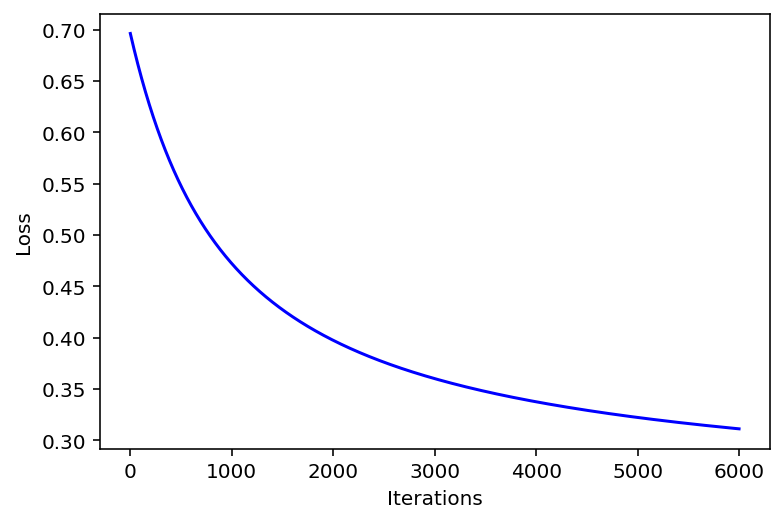

In [142]:
plt.plot(my_LR.loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

Podemos dibujar los pesos del regresor logístico. Con `.detach()` desvinculamos el tensor de sus gradientes y luego pasamos a numpy array ... 

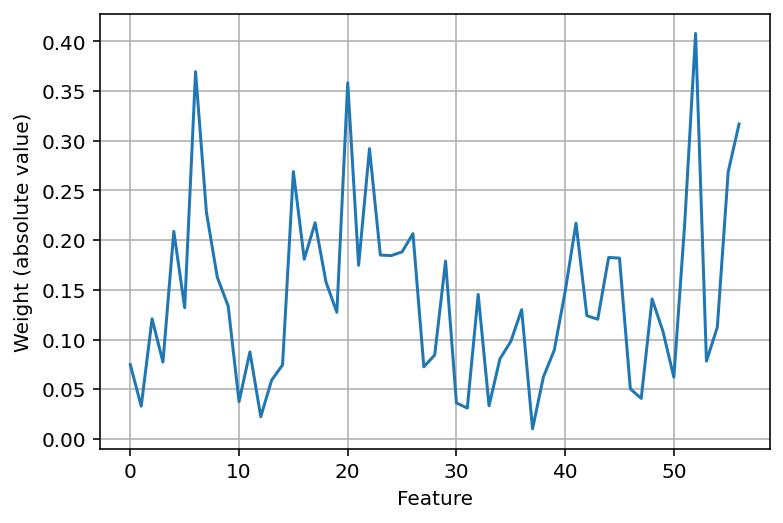

In [143]:
#Your code here

plt.plot(np.abs(list(my_LR.parameters())[0].reshape([-1,]).detach().numpy()))
plt.grid()
plt.xlabel('Feature')
plt.ylabel('Weight (absolute value)')
plt.show()

#### Evaluación del modelo en el conjunto de prueba

Ahora que hemos entrenado a nuestro regresor logístico, es hora de comparar sus prestaciones tanto en el entrenamiento como en el conjunto de test.

> **Ejercicio**: Complete el siguiente código para obtener la salida del regresor logístico para los datos los datos de test y obtener la curva ROC

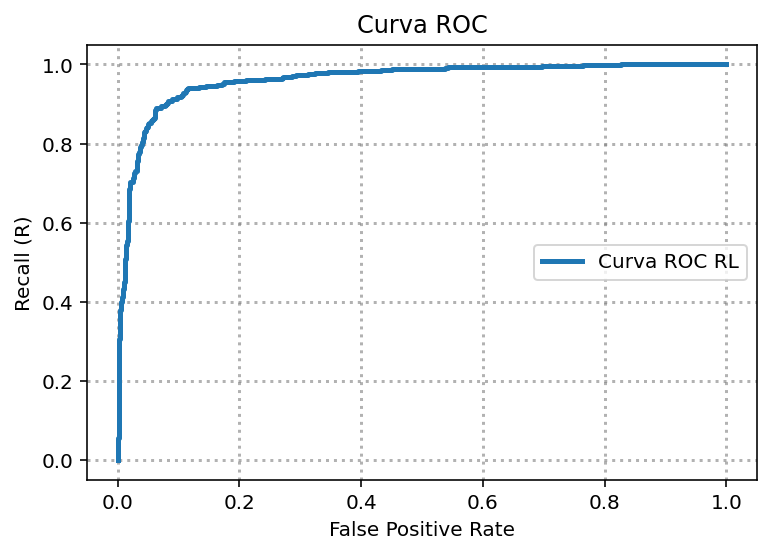

El área bajo la curva ROC de RL es 0.961824327237297


In [155]:
out_test = my_LR.forward(#####).detach().numpy().reshape([-1,])

from sklearn import metrics

fpr, recall, thresholds = metrics.roc_curve(y_test, ######, pos_label=1) 

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Curva ROC RL')

plt.legend(loc=7)
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()

area_roc = metrics.roc_auc_score(y_test, #####)

print(f"El área bajo la curva ROC de RL es {area_roc}")

## Parte V.Entrenamiento de un regresor logístico con descenso de gradiente estocástico con minibatches

Finalmente, vamos a implementar una versión escalable del entrenamiento de descenso de gradiente implementado anteriormente. En cada iteración, en lugar de evaluar el gradiente usando todos los puntos de datos, se usará un pequeño minibatch de datos.

En lugar de predefinir un cierto número de iteraciones SGD, definimos un cierto número de **épocas**. Después de cada época, **todos los puntos de datos** se han utilizado en el optimizador una vez.


In [145]:

class LR_stochastic(LR_compact):
    
    def __init__(self,dimx,num_train_data,
                 epochs=100,lr=0.001,batch_size=50,print_every=20):
        
        super().__init__(dimx)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.SGD(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.print_every = print_every  # Print loss every 
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.num_train = num_train_data
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        
        
    def trainloop(self,x,y):
        
        # Bucle sobre las épochas
        
        for e in range(int(self.epochs)):
            
            # Permutamos los datos aleatoriamente en cada época
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            
            for i in range(int(self.num_batchs)):
        
                self.optim.zero_grad()  #Reiniciamos gradientes
            
                # Indices de los datos que participan en el batch
            
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]
                
                # Salida de la NN para el batch

                out = self.forward(x[idx_batch,:]) 

                #Función de coste par el batch
                loss = self.criterion(out,y[idx_batch].view(self.batch_size,1))

                running_loss += loss.item()

                #Calculamos gradientes
                loss.backward()
                
                #Una iteración de descenso por gradiente
                self.optim.step()
                
            self.loss_during_training.append(running_loss/self.num_batchs)

            if(e % self.print_every == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


> **EjerciciO**: Entrene un regresor logístico con descenso de gradiente estocástico minibatch con tamaño de batch 100 y dibuje la evolución de la función de pérdida.

Training loss after 0 epochs: 0.712874
Training loss after 100 epochs: 0.351183
Training loss after 200 epochs: 0.307013
Training loss after 300 epochs: 0.288626
Training loss after 400 epochs: 0.276350


Text(0, 0.5, 'Loss')

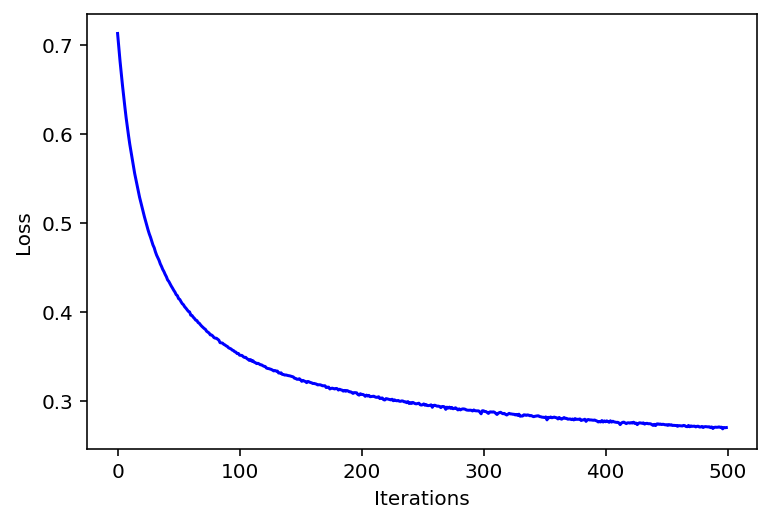

In [146]:
#Your code here

> **Ejercicio**: Para el RL entrenado, dibuje la curva ROC y determine el área bajo la curva

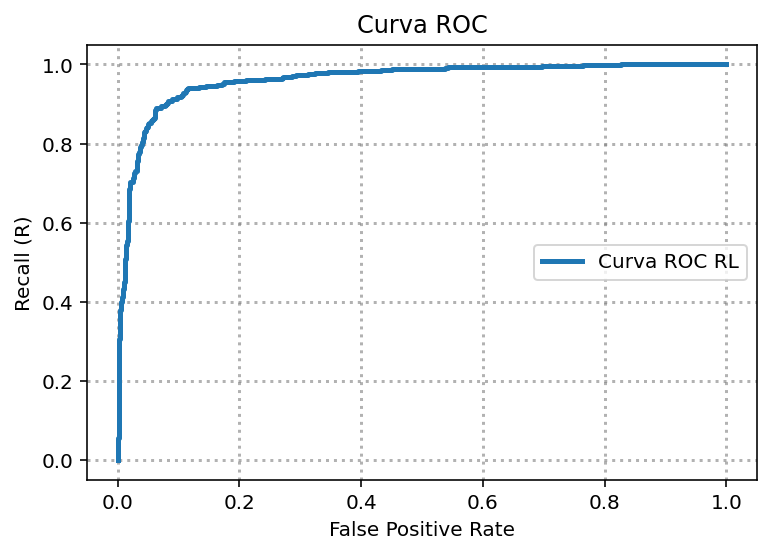

El área bajo la curva ROC de RL es 0.961824327237297


In [154]:
### YOUR CODE HERE

## 2. Entrene a un MLP para que haga el mismo trabajo

Modificar el código anterior para implementar una red neuronal de tipo MLP es muy sencillo. Supongamos que queremos entrenar un MLP con tres capas, todas usando unidades lineales rectificadas (RELU) como activaciones no lineales (excepto la última capa, que usa una sigmoide). La primera capa tiene 100 unidades ocultas y la segunda 50 de ellas.

In [148]:
from IPython.display import Image

Image(url= "https://pytorch.org/docs/stable/_images/ReLU.png", width=300, height=100)

Al igual que con el LR, creamos una clase pequeña que define el modelo y luego una clase más grande de la que hereda para incorporar el entrenamiento.

> **Ejercicio**: Completa el código para la siguiente clase

In [149]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2): # 3 capas. Definimios como inputs del constructor la dimensión de los datos y el número de unidades ocultas en las dos capas intermedias
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1) # Primera capa lineal
        
        self.output2 = ### YOUR CODE HERE # Segunda capa lineal
        
        self.output3 = nn.Linear(hidden2,1) # Tercera capa lineal. Salida es un escalar
    
        self.relu = nn.ReLU() # Activación en las capas 1 y 2
        
        self.sigmoid = nn.Sigmoid()                                                           
        
    def forward(self, x):
        # Definimos todas las operaciones para determinar la salida
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.### YOUR CODE HERE
        x = self.### YOUR CODE HERE
        return x

In [150]:
'''Extendemos la clase y añadimos entrenamiento SGD estocástico. Esta es casi idéntica a la implementada para el RL!!!'''

class MLP_stochastic(### YOUR CODE HERE):
    
    def __init__(self,dimx,hidden1,hidden2,num_train_data,
                 epochs=100,lr=0.001,batch_size=50,print_every=20):
        
        super().__init__(### YOUR CODE HERE)  #Inicializamos la clase padre
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.print_every = print_every  # Print loss every 
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.num_train = num_train_data
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)    
        
    def trainloop(self,x,y):
        
        ### YOUR CODE HERE


> **Ejercicio**: entrene la red MLP durante 100 épocas y obtenga la curva ROC. Comparela con la curva ROC del RL.

In [151]:
### YOUR CODE HERE

Training loss after 0 epochs: 0.586999
Training loss after 10 epochs: 0.138459
Training loss after 20 epochs: 0.091003
Training loss after 30 epochs: 0.065071
Training loss after 40 epochs: 0.048477
Training loss after 50 epochs: 0.040078
Training loss after 60 epochs: 0.033986
Training loss after 70 epochs: 0.026885
Training loss after 80 epochs: 0.038724
Training loss after 90 epochs: 0.024773


Text(0, 0.5, 'Loss')

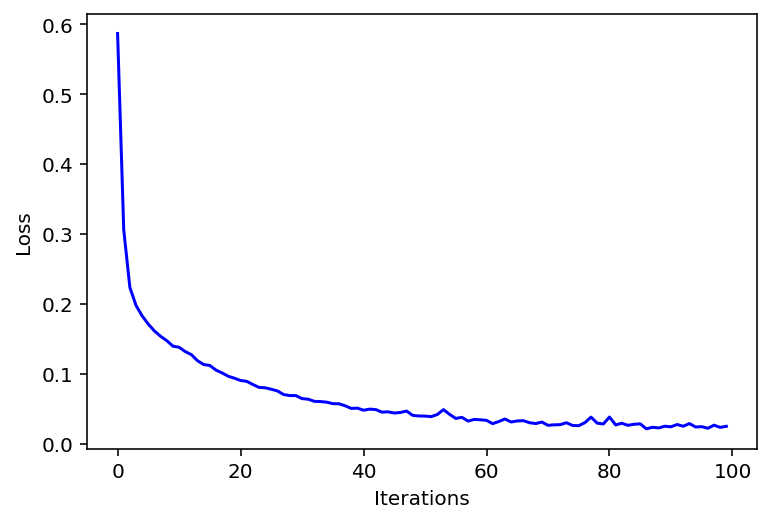

In [152]:
### YOUR CODE HERE

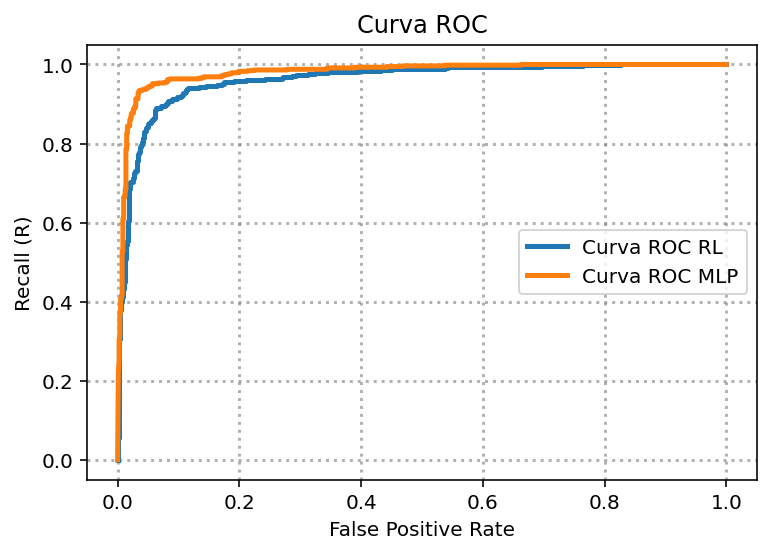

El área bajo la curva ROC de RL es 0.961824327237297
El área bajo la curva ROC de MLP es 0.9802611724738526


In [156]:
### YOUR CODE HERE

> **Ejercicio**: Repita el ejercicio anterior aumentando el número de unidades ocultas de la red

In [165]:
### YOUR CODE HERE

In [166]:
### YOUR CODE HERE

Training loss after 0 epochs: 0.496358
Training loss after 10 epochs: 0.115086
Training loss after 20 epochs: 0.079207
Training loss after 30 epochs: 0.050917
Training loss after 40 epochs: 0.044691
Training loss after 50 epochs: 0.029642
Training loss after 60 epochs: 0.049592
Training loss after 70 epochs: 0.022071
Training loss after 80 epochs: 0.020647
Training loss after 90 epochs: 0.020289


Text(0, 0.5, 'Loss')

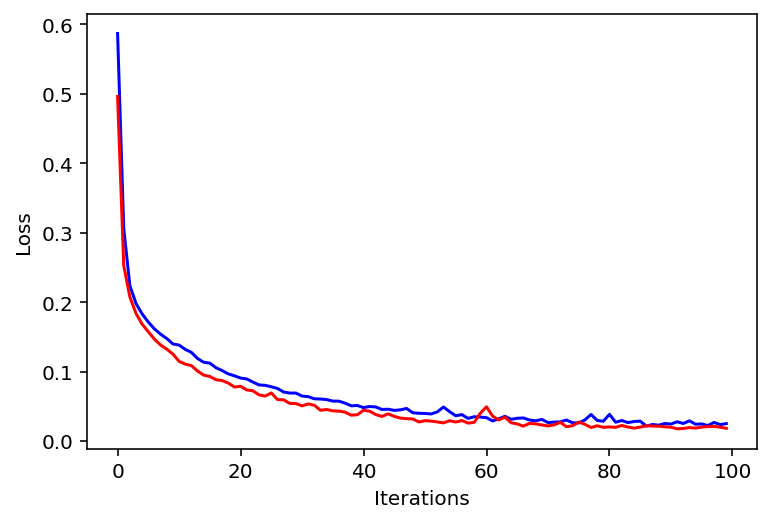

In [167]:
### YOUR CODE HERE

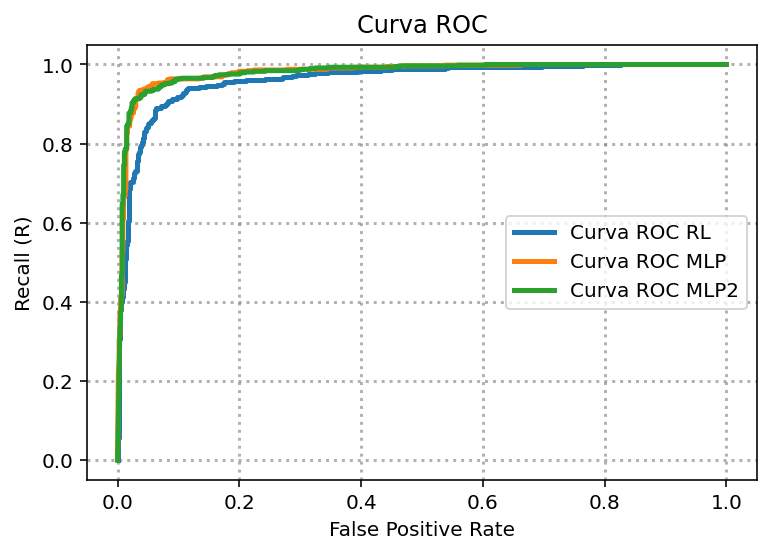

El área bajo la curva ROC de RL es 0.961824327237297
El área bajo la curva ROC de MLP es 0.9802611724738526
El área bajo la curva ROC de MLP es 0.9802234494770515


In [168]:
### YOUR CODE HERE

> **Ejercicio:** Visualicemos las activaciones en la salida de la primera capa para los 100 primeros datos de test. Esto ayudará a identificar posibles unidades ocultas no utilizadas (siempre activadas / desactivadas) y unidades ocultas correlacionadas, estos, unidades redundantes. 
>
> Complete el siguiente código.

In [ ]:
# Activaciones a la salida de la primera capa

activations = my_MLP_2.relu(###.output1(#####)).detach().numpy() # YOUR CODE HERE

activations.shape

In [ ]:
# Dibujemos la matriz de activaciones

plt.matshow(####[:100,:].T)

plt.colorbar()

fig = plt.gcf()

fig.set_size_inches(15, 10)

Dibujemos la varianza por dimensión ...

In [ ]:
plt.plot(np.var(activations,####))
plt.grid()
plt.xlabel('Unidad oculta')
plt.ylabel('Varianza')


Podemos ver cómo hay una gran cantidad de unidades ocultas con una varianza baja (~0.25) que potencialmente pueden ser eliminadas, simplificando la red y reduciendo el número de parámetros.

### Guardar y restaurar el modelo

Finalmente, vamos a mostrar cómo guardar y cargar modelos (es decir, los valores de los parámetros) con PyTorch. Esto es importante porque a menudo querremos cargar modelos previamente entrenados para usarlos al hacer predicciones o continuar entrenando con datos nuevos.

Los parámetros para las redes PyTorch se almacenan en un diccionario denominado `state_dict`. Este diccionario contiene las matrices de peso y sesgo para cada una de nuestras capas.

In [ ]:
print("Our model: \n\n", my_MLP, '\n')
print("The state dict keys: \n\n", my_MLP.state_dict().keys())

Para guardar el modelo, usaremos `torch.save`. Guardaremos los archivos con extension `.pth`.

In [ ]:
torch.save(my_MLP.state_dict(), 'checkpoint.pth')

Podemos recargar el diccionario con `torch.load` y cargar `state_dict` en la red con `my_MLP.load_state_dict(state_dict)`

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

my_MLP.load_state_dict(state_dict)

**Importante:** `load_state_dict` nos dará un error si la arquitectura de la red es differente de la que hemos salvado en el archivo pth